In [492]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset  # from HuggingFace Datasets
from scipy.spatial.distance import pdist,cdist, squareform

# Load the BBC News dataset
# Using Hugging Face version
dataset = load_dataset("SetFit/bbc-news")  # has 2,225 articles with the 5 labels. 

texts = dataset["train"]["text"]
labels = dataset["train"]["label"]
# You may want a smaller subset, e.g. sample 500–1000 to speed up TSNE
#sample_size = 1000
#np.random.seed(0)
#indices = np.random.choice(len(texts), sample_size, replace=False)
#texts_s = [texts[i] for i in indices]
#labels_s = [labels[i] for i in indices]

# Vectorize with TF-IDF
#vectorizer = TfidfVectorizer(max_features=1200, stop_words="english", ngram_range=(1,5))
#X = vectorizer.fit_transform(texts).toarray()

import pickle
# Load the array
with open("robert_embeddings_BBC.pkl", "rb") as f:
    X = pickle.load(f)



In [700]:
from tqdm import tqdm 

feature_sizes = [5, 10, 20, 100,2000]

pdists = []

for f in tqdm(feature_sizes):
    vectorizer = TfidfVectorizer(max_features=f, stop_words="english", ngram_range=(1,5))
    X = vectorizer.fit_transform(texts).toarray()
    pdists.append(pdist(X))


100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


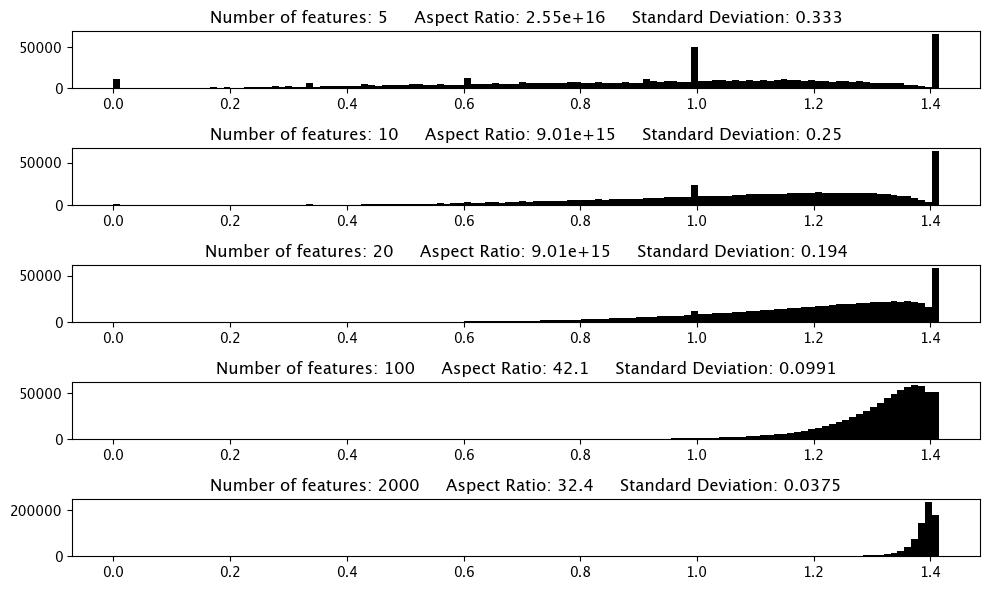

In [716]:
fig, axs = plt.subplots(5,1, figsize=(10,6))

# Adjust the spacing
plt.subplots_adjust(
    left=0.1,    # left side of the subplots of the figure
    right=0.9,   # right side of the subplots of the figure
    bottom=0.1,  # bottom of the subplots of the figure
    top=0.9,     # top of the subplots of the figure
    wspace=0.4,  # amount of width reserved for blank space between subplots
    hspace=0.4   # amount of height reserved for white space between subplots
)

for i in range(5):
    ix = np.where(pdists[i] > 0)
    ar = max(pdists[i])/min(pdists[i][ix])
    avg = np.std(pdists[i])

    axs[i].set_title(f'Number of features: {feature_sizes[i]} \t\t\t Aspect Ratio: {ar:.3g} \t\t\t Standard Deviation: {avg:.3g}')
    axs[i].hist(pdists[i] , bins=120, color='black')
plt.tight_layout()
plt.savefig('visuals/bbc/dist_hist.png', bbox_inches='tight')

In [504]:
# remove points that have dubplicate Roberta embeddings
X, ix = np.unique(X, axis=0, return_index=True)
labels_new = np.array(labels)[ix]

In [634]:
X.shape

(1191, 768)

In [489]:
print(X.shape)

(1191, 768)


In [445]:
# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
X_emb = tsne.fit_transform(X)#[new_ixs])

237.31268826175068


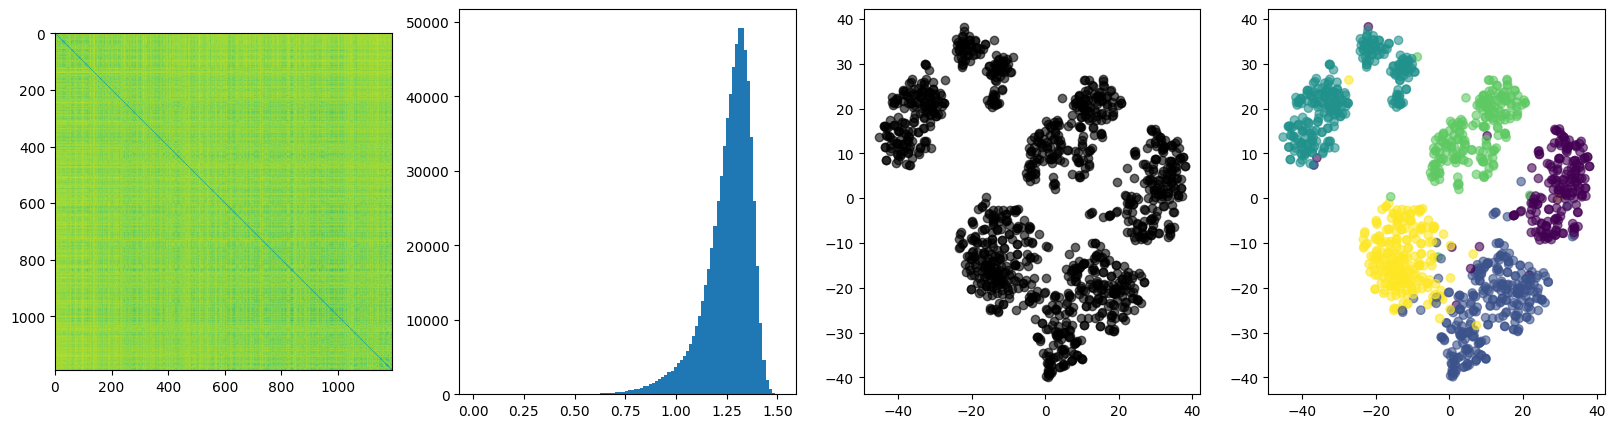

In [446]:


fig, axs = plt.subplots(1,4, figsize=(20,5))
distlist = pdist(X)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_emb[:,0], X_emb[:,1], c='black', alpha=0.6)
axs[3].scatter(X_emb[:,0], X_emb[:,1], c=labels_new, alpha=0.6)
print(max(distlist) / min(distlist))

DBSCAN almost gets it!


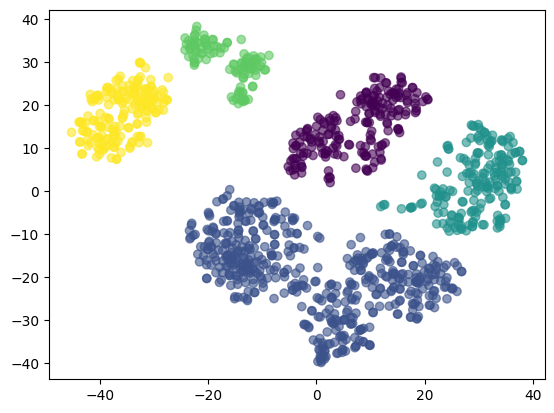

In [559]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=4.2, min_samples=5).fit(X_emb)
dbscan_labelling = db.labels_  # cluster labels, -1 means noise
plt.scatter(X_emb[:,0], X_emb[:,1], c=dbscan_labelling, alpha=0.6)
print('DBSCAN almost gets it!')

In [562]:
from sklearn.metrics import silhouette_score
### silhouette score of t-sne
print('silhouette score of true labels on t-SNE', silhouette_score(X_emb, labels_new))

silhouette score of true labels on t-SNE 0.5037126


237.31268826175068


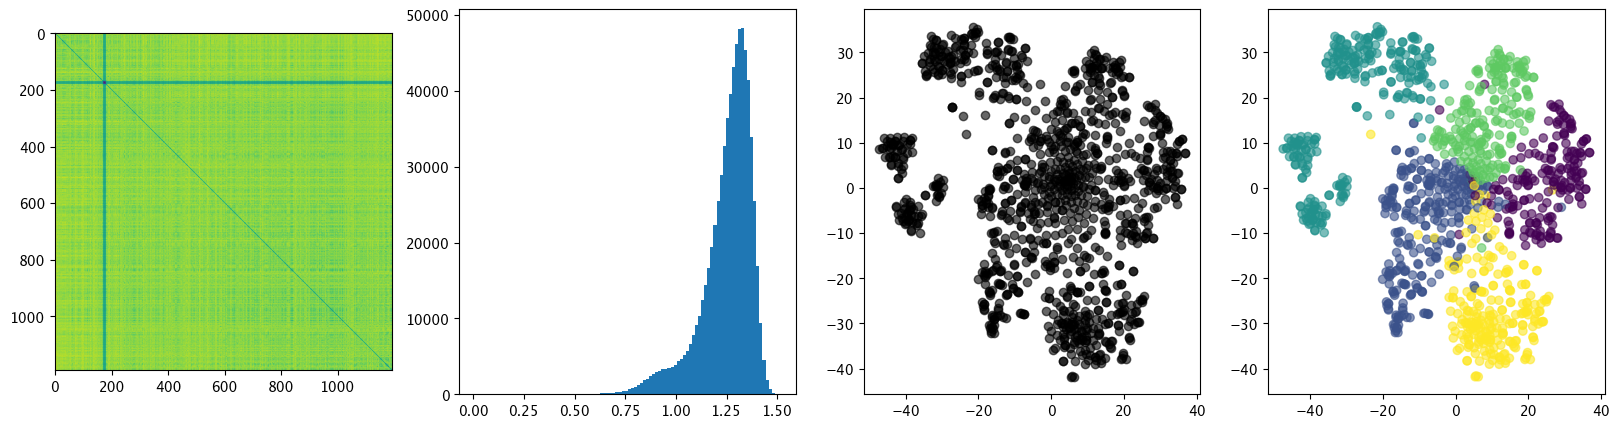

In [666]:
X_alt = X.copy()

from sklearn.cluster import KMeans
d=X_alt.shape[1]


#kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X_alt)

"""rand_ix = 300
num_bad = 2
for i in range(k):
    mu = kmeans.cluster_centers_[i]
    X_alt[rand_ix + i*num_bad: rand_ix + (i+1)*num_bad] = mu"""
rand_ix = 170
num_bad = 10
for i in range(num_bad):
    ### STRAT 1
    idx = np.random.choice(X.shape[0], size=40, replace=False)
    X_alt[rand_ix + i] = np.mean(X[idx], axis=0) #+  np.random.normal(size=(d)) / (5*d**0.5)
    #ids = np.random.choice(5, size=2, replace=False)
    #X_alt[rand_ix + i] = np.mean(X[np.where( (labels==ids[0])|(labels==ids[1]) )], axis=0) +  np.random.normal(size=(d)) / (5*d**0.5)


colors_new = np.array(labels)
colors_new[rand_ix:rand_ix + num_bad] = -1
#X_alt[10] = np.mean(X_alt, axis=0) #+ np.random.normal(size=(d)) / d**0.5
#X_alt[23] = np.mean(X_alt, axis=0)# + np.random.normal(size=(d)) / d**0.5
#X_alt[130] = np.mean(X_alt, axis=0) #+ np.random.normal(size=(d)) / d**0.5

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_emb_ = tsne.fit_transform(X_alt)

fig, axs = plt.subplots(1,4, figsize=(20,5))
distlist = pdist(X_alt)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_emb_[:,0], X_emb_[:,1], c='black', alpha=0.6)
axs[3].scatter(X_emb_[:,0], X_emb_[:,1], c=labels_new, alpha=0.6)
print(max(distlist) / min(distlist))


/Users/noahbergam/Desktop/tsne-mode-collapse/umap_env2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


237.31268826175068


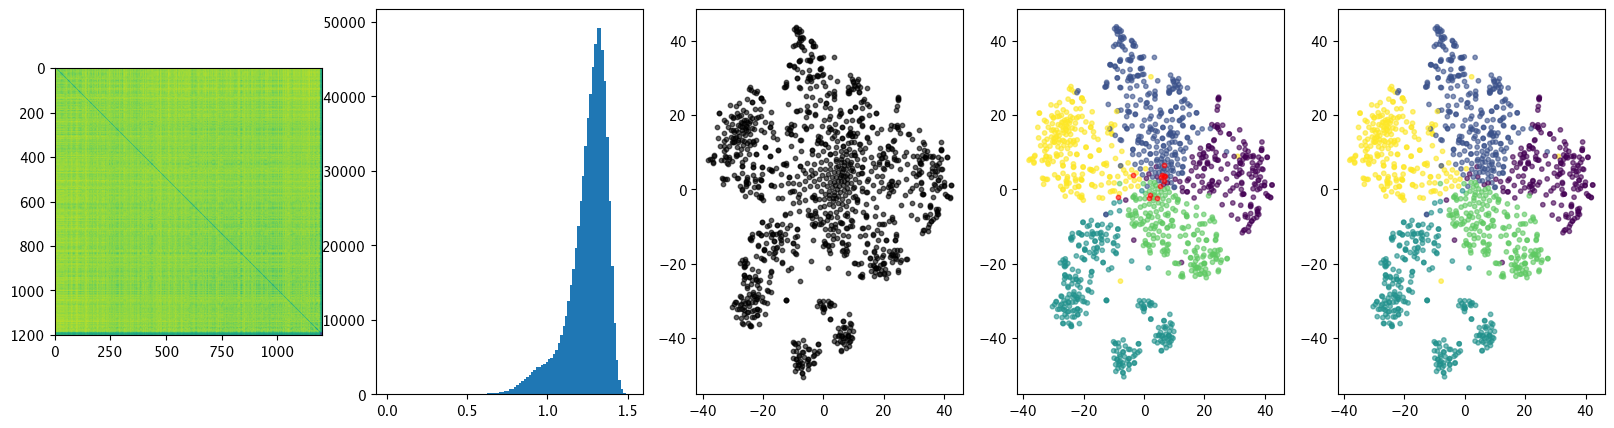

In [681]:
X_alt = X.copy()
labels_alt = labels_new.copy().tolist()

from sklearn.cluster import KMeans
d=X_alt.shape[1]

#m1 = np.mean( X_alt[ np.where((labels_alt==0) | (labels_alt==1)) ] , axis=0) 
#m2 = np.mean( X_alt[ np.where((labels_alt==2) | (labels_alt==3) | (labels_alt==4)) ] , axis=0) 

km = KMeans(n_clusters=2, random_state=0).fit(X_alt)


m = 12
n = X.shape[0]

for i in range(int(m/2)):
    idx = np.random.choice(n, size=5, replace=False)
    mu = np.mean(X_alt[idx], axis=0)

    X_alt = np.concatenate((X_alt,[ (km.cluster_centers_[0]  + mu)/2    ]), axis=0)
    #idx = np.random.choice(n, size=50, replace=False)
    #mu = np.mean(X_alt[idx], axis=0)
    #X_alt = np.concatenate((X_alt,[mu]), axis=0)
    labels_alt.append(-10)

for i in range(int(m/2)):
    idx = np.random.choice(n, size=5, replace=False)
    mu = np.mean(X_alt[idx], axis=0)

    X_alt = np.concatenate((X_alt,[ (km.cluster_centers_[1]  + mu)/2 ]), axis=0)
    labels_alt.append(-10)


tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_emb_ = tsne.fit_transform(X_alt)

fig, axs = plt.subplots(1,5, figsize=(20,5))
distlist = pdist(X_alt)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_emb_[:,0], X_emb_[:,1], s=10, c='black', alpha=0.6)
axs[3].scatter(X_emb_[:-m,0], X_emb_[:-m,1], s=10, c=labels_alt[:-m], alpha=0.6)
axs[3].scatter(X_emb_[-m:,0], X_emb_[-m:,1], s=10, c='red', alpha=0.6)
axs[4].scatter(X_emb_[:-m,0], X_emb_[:-m,1], s=10, c=labels_alt[:-m], alpha=0.6)
print(max(distlist) / min(distlist))


In [622]:
print('silhouette score of true labels on t-SNE', silhouette_score(X_emb_[:-m], labels_new))

silhouette score of true labels on t-SNE 0.3287931


In [671]:
### alternative regime: inject a ton of faraway outliers!!

X_alt2 = X.copy()

m = 1191
labels_new_ = labels_new.copy().tolist()
for i in range(m):
    outlier = np.random.normal(size=(X_alt2.shape[1])) / 3
    X_alt2 = np.concatenate((X_alt2, np.array( [outlier])), axis=0)
    labels_new_.append(-1)


tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
X_emb__ = tsne.fit_transform(X_alt2)



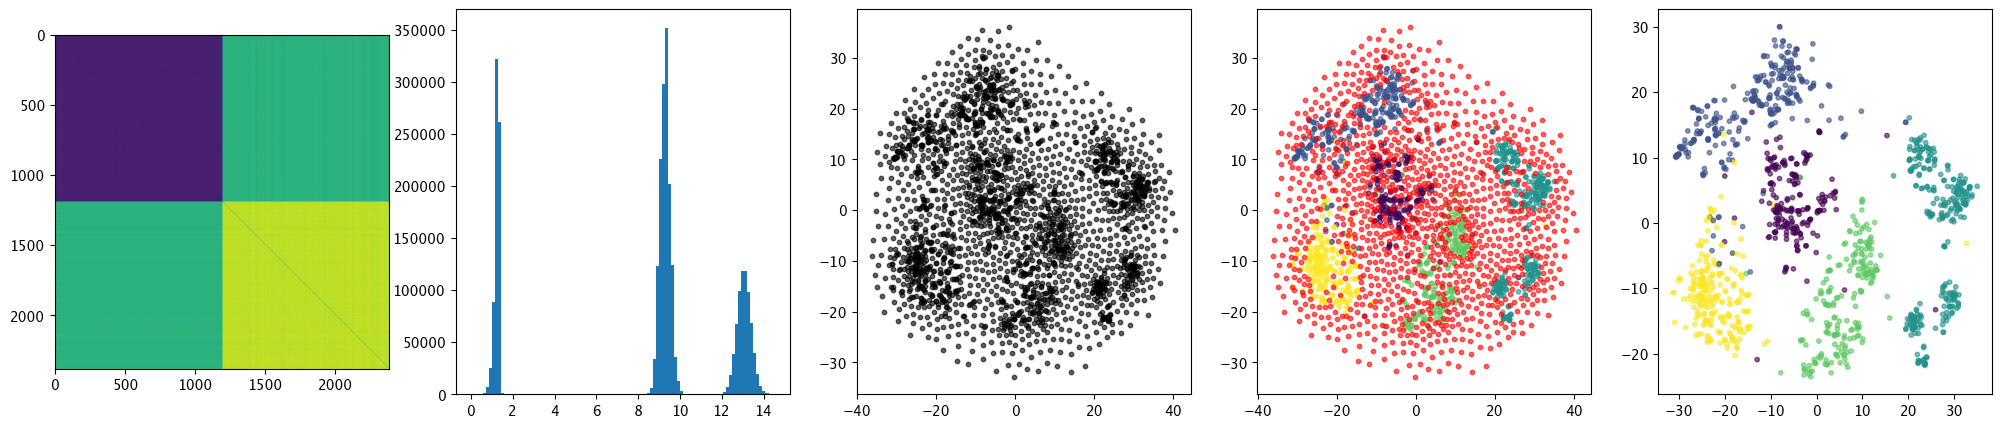

In [672]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
distlist = pdist(X_alt2)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_emb__[:,0], X_emb__[:,1], s = 10, c='black', alpha=0.6)
axs[3].scatter(X_emb__[:-m,0], X_emb__[:-m,1],s = 10,  c=labels_new_[:-m], alpha=0.6)
axs[3].scatter(X_emb__[-m:,0], X_emb__[-m:,1],s = 10,  c='red', alpha=0.6)
axs[4].scatter(X_emb__[:-m,0], X_emb__[:-m,1], s = 10, c=labels_new_[:-m], alpha=0.6)

In [566]:
print('silhouette score of true labels on t-SNE', silhouette_score(X_emb__[:-m], labels_new))

silhouette score of true labels on t-SNE 0.48628312


In [ ]:
def unique_by_distance(X, threshold):
    """
    Remove rows of X that are within Euclidean distance < threshold of another row.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        Input data matrix.
    threshold : float
        Distance threshold for merging points.
    
    Returns
    -------
    X_unique : ndarray
        Filtered array with duplicates (under distance threshold) removed.
    keep_idx : ndarray
        Indices of rows kept in the original array.
    """
    keep_idx = []
    seen = []

    for i, row in enumerate(X):
        if not seen:   # keep the first point
            seen.append(row)
            keep_idx.append(i)
        else:
            dists = np.linalg.norm(np.array(seen) - row, axis=1)
            if np.all(dists >= threshold):
                seen.append(row)
                keep_idx.append(i)
    
    return X[keep_idx], np.array(keep_idx)

XXX, new_ixs  = unique_by_distance(X, .5)
yyy = np.array(labels_new)[new_ixs.tolist()]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
X_emb2 = tsne.fit_transform(XXX)#[new_ixs])

fig, axs = plt.subplots(1,4, figsize=(20,5))
distlist = pdist(XXX)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_emb2[:,0], X_emb2[:,1], c='black', alpha=0.6)
axs[3].scatter(X_emb2[:,0], X_emb2[:,1], c=yyy, alpha=0.6)
print(max(distlist) / min(distlist))

array([1.41056662, 1.37377426, 1.39271846, ..., 1.38059531, 1.40172132,
       1.39061878])

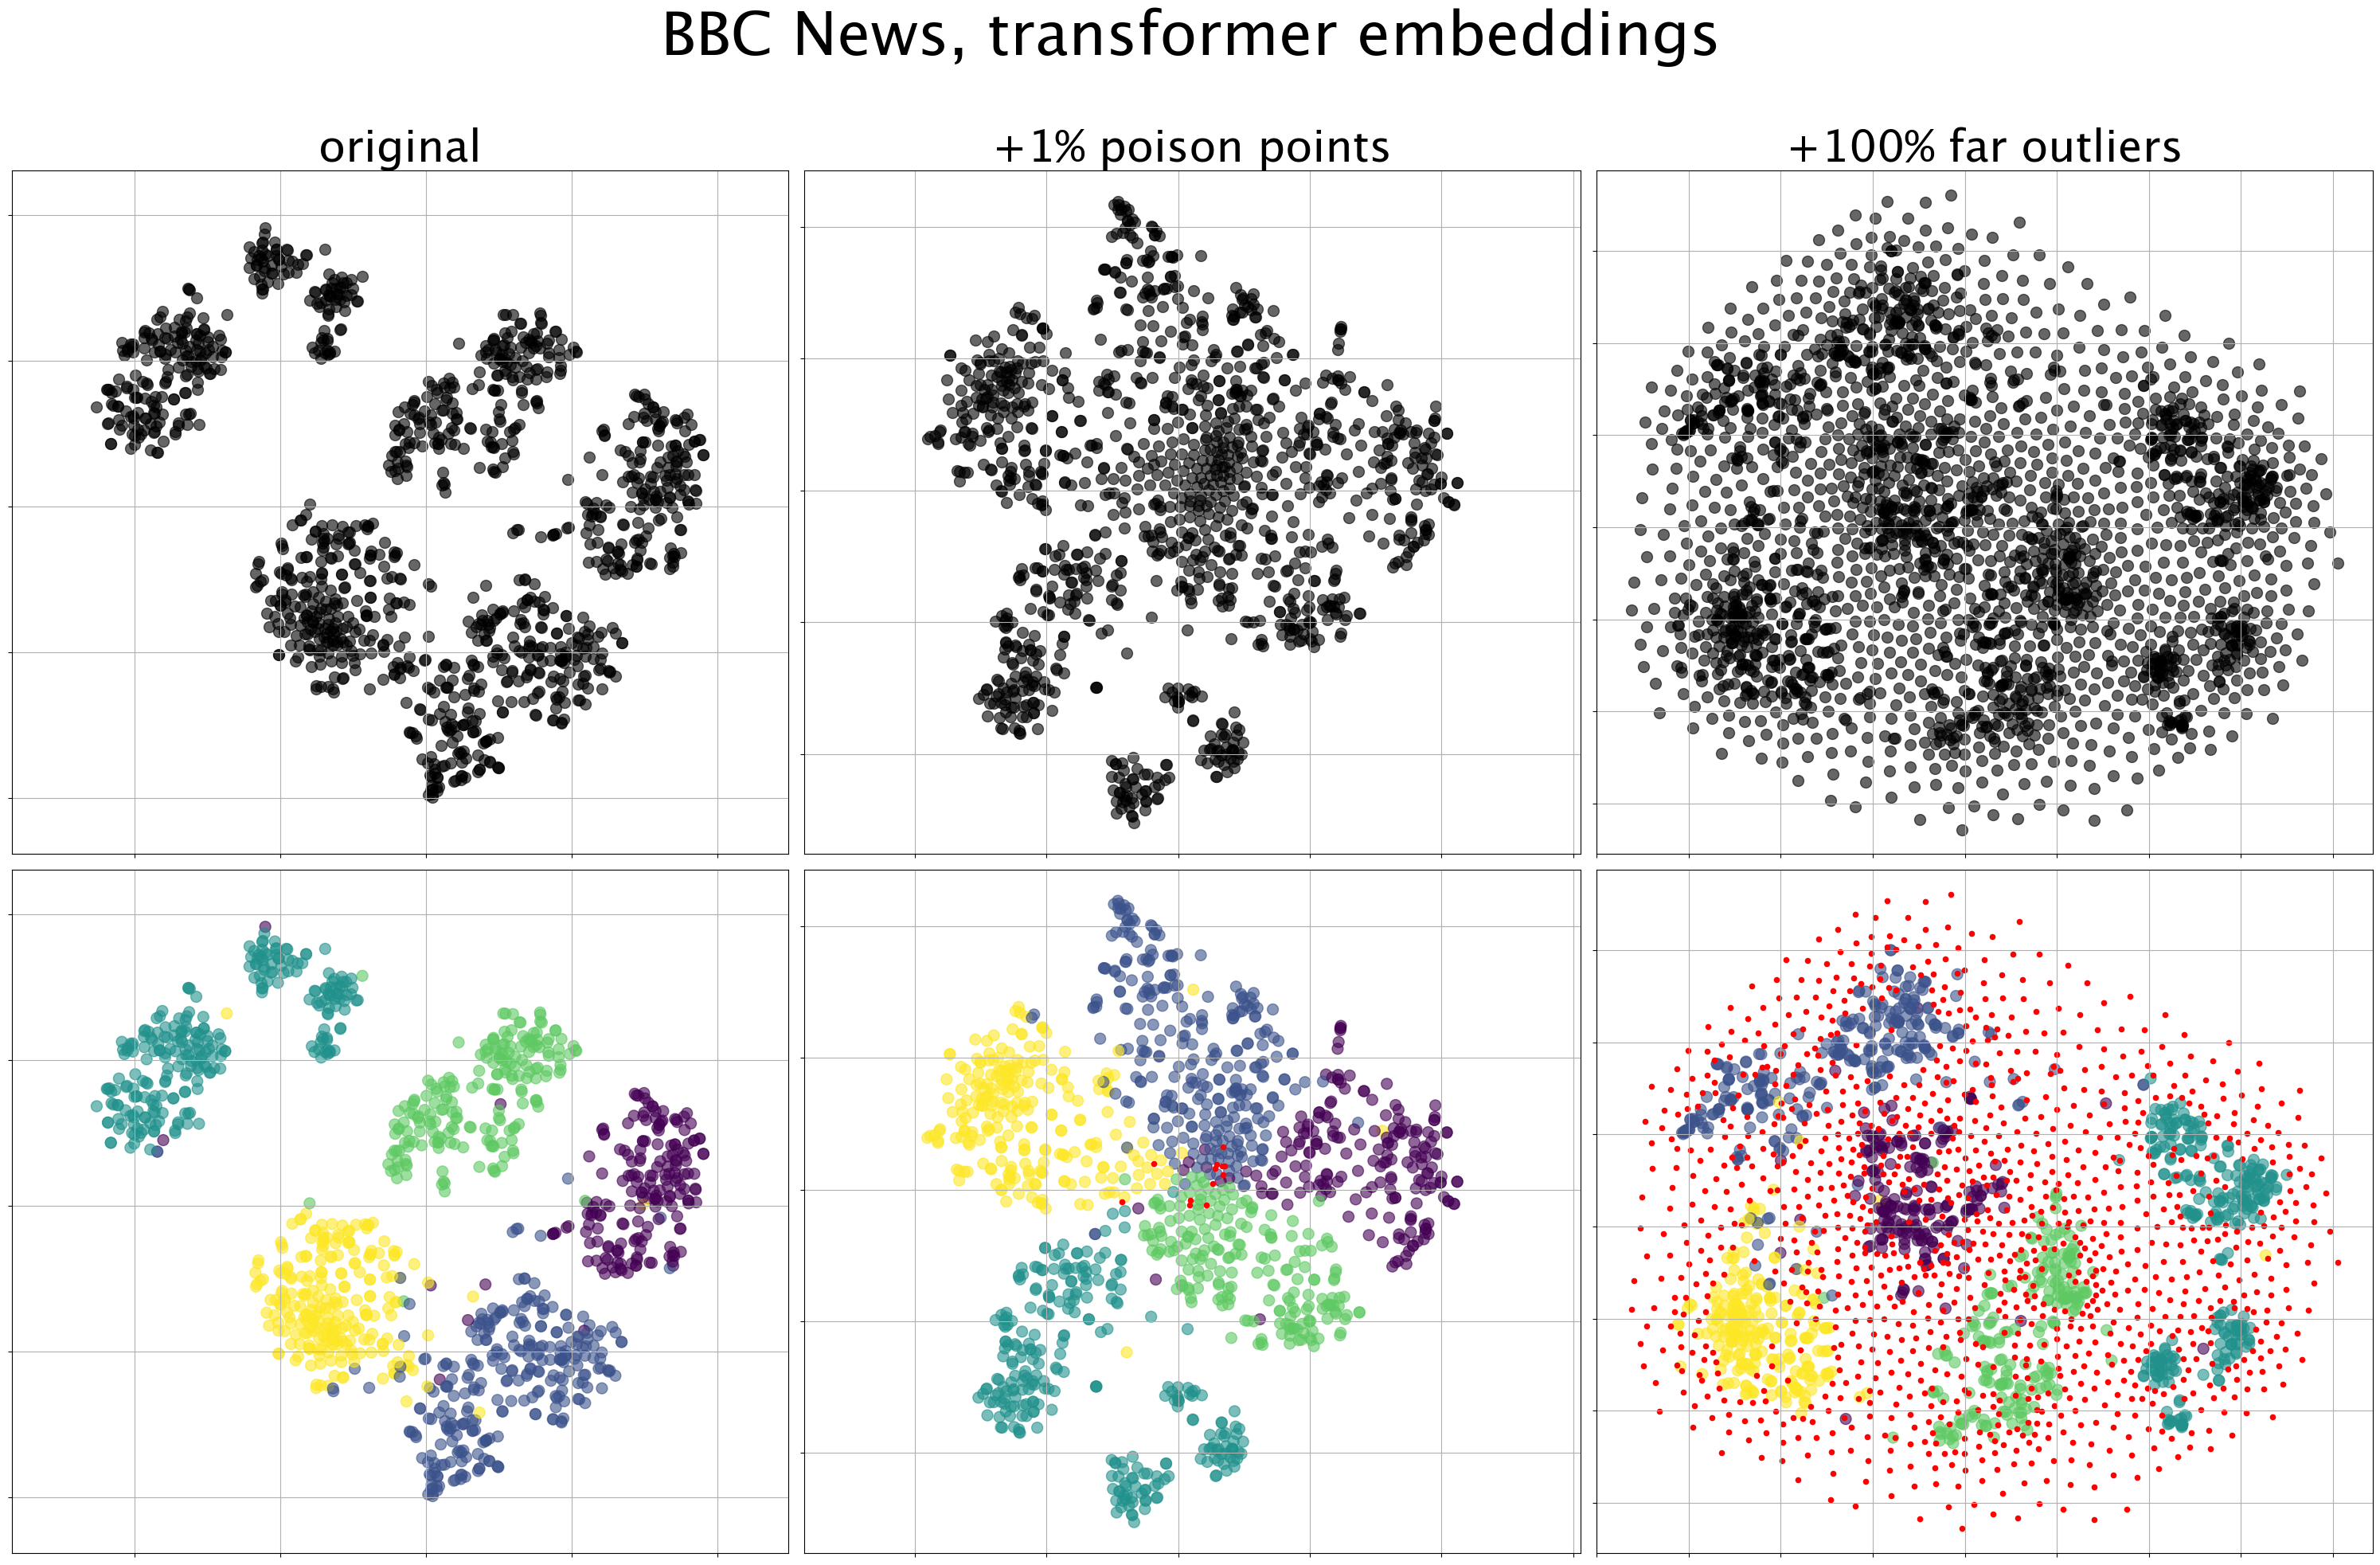

In [684]:
fig, axs = plt.subplots(2,3, figsize=(30,20))

for i in range(2):
    for j in range(3):
        axs[i,j].grid('on')
        axs[i,j].axis('equal')
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])


axs[0,0].set_title('original', fontsize=40)
axs[0,0].scatter(X_emb[:,0], X_emb[:,1], s=100,c='black', alpha=0.6)
axs[1,0].scatter(X_emb[:,0], X_emb[:,1], s=100, c=labels_new, alpha=0.6)
m=12
axs[0,1].set_title('+1% poison points', fontsize=40)
axs[0,1].scatter(X_emb_[:,0], X_emb_[:,1], s=100, c='black', alpha=0.6)
axs[1,1].scatter(X_emb_[:-m,0], X_emb_[:-m,1], s=100, c=labels_alt[:-m], alpha=0.6)
axs[1,1].scatter(X_emb_[-m:,0], X_emb_[-m:,1], s=20, c='red', alpha=1)
m=1191
axs[0,2].set_title('+100% far outliers', fontsize=40)
axs[0,2].scatter(X_emb__[:,0], X_emb__[:,1], s = 100, c='black', alpha=0.6)
axs[1,2].scatter(X_emb__[:-m,0], X_emb__[:-m,1],s = 100,  c=labels_new_[:-m], alpha=0.6)
axs[1,2].scatter(X_emb__[-m:,0], X_emb__[-m:,1],s = 20,  c='red', alpha=1)

plt.suptitle('BBC News, transformer embeddings\n', fontsize=55)
plt.tight_layout()
plt.savefig('visuals/bbc/internal_vs_external_BBC.png')